# Replicating Berentsen et al. (AER 2011)

*Author: Mohammed Aït Lahcen, University of Basel*

In this notebook I try to replicate some results from the AER paper by Berentsen et al. (2011).

In [24]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.integrate import quad as integrate
from scipy.misc import derivative
from numba import jit

import seaborn as sns  # Better quality figures
%matplotlib notebook
# Displays figures inside the notebook
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D
rcParams['figure.figsize'] = (12, 8)  # Sets the size of the figures in the notebook

## Data

We start by importing the data used for the calibration and simulation parts. This consists on quarterly time series over the period 1955-2005 for:
* Money demand (M1/Nominal GDP, annualized)
* Interest rate (AAA corporate bonds, annualized, percent)
* Inflation (annualized, percent)
* Unemployment (percent)

In [25]:
data = pd.read_csv('exportable_data.csv', sep=',', names=['M1/PY', 'unemployment', 'i-AAA', 'inflation'])

data = data.drop(data.index[:28])  # Drop data before 1955

print(data.count(axis=0))

m_data = data['M1/PY']  # Money demand
u_data = data['unemployment'] / 100
p_data = ((1 + (data['inflation'] / 100)) ** (1 / 4)) - 1  # Transform into quarterly series
i_ann_data = data['i-AAA'] / 100
i_data = ((1 + (data['i-AAA'] / 100)) ** (1 / 4)) - 1  # Transform into quarterly rates

M1/PY           204
unemployment    204
i-AAA           204
inflation       204
dtype: int64


Next, we extract the long run component of the data using an HP-filter with paramater set at 1600 as is usual in the literature.

In [26]:
m_cycle, m_trend = sm.tsa.filters.hpfilter(m_data, 1600)
u_cycle, u_trend = sm.tsa.filters.hpfilter(u_data, 1600)
i_cycle, i_trend = sm.tsa.filters.hpfilter(i_data, 1600)
p_cycle, p_trend = sm.tsa.filters.hpfilter(p_data, 1600)

Below, I replicate figure 1 of the paper.

<IPython.core.display.Javascript object>


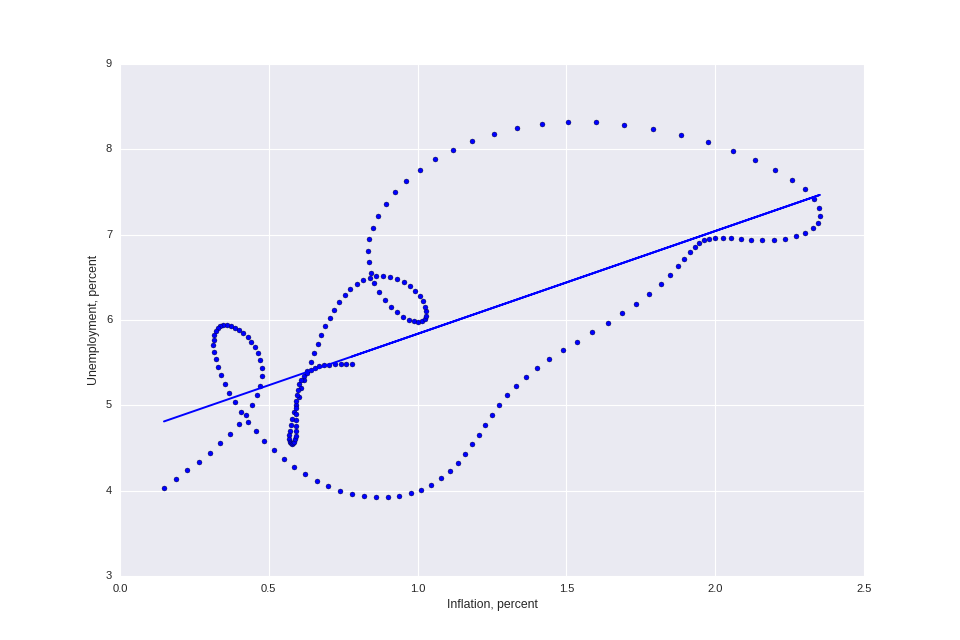

In [27]:
plt.figure(1)
results = sm.OLS(u_trend, sm.add_constant(p_trend),missing='drop').fit()
a, b = results.params
plt.plot(p_trend*100, (a + b*p_trend)*100,'b')
plt.scatter(p_trend*100,u_trend*100)
plt.xlabel('Inflation, percent')
plt.ylabel('Unemployment, percent')
#plt.xlim(0,0.03)
#plt.ylim(0,0.10)
plt.show()

Next, I compute some moments of the data that will be used later as targets in the calibration part.

In [28]:
m_mean = np.mean(m_data)
i_mean = np.mean(i_data)
p_mean = np.mean(p_data)
u_mean = np.mean(u_data)

print('m_mean =','{:04.2f}'.format(m_mean*100),'%')
print('i_mean =','{:05.2f}'.format(i_mean*100),'%')
print('p_mean =','{:05.2f}'.format(p_mean*100),'%')
print('u_mean =','{:05.2f}'.format(u_mean*100),'%')

m_mean = 17.89 %
i_mean = 01.80 %
p_mean = 00.98 %
u_mean = 05.81 %


I also estimate money demand elasticity based on the annualized unfiltered data using a log-log specification: $\log(m) = \alpha + \beta\log(i)$:

In [29]:
results = sm.OLS(np.log(m_data), sm.add_constant(np.log(data['i-AAA']))).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  M1/PY   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     179.1
Date:                Thu, 28 Jul 2016   Prob (F-statistic):           1.16e-29
Time:                        21:30:31   Log-Likelihood:                 21.809
No. Observations:                 204   AIC:                            -39.62
Df Residuals:                     202   BIC:                            -32.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.6873      0.082     -8.367      0.0

In [30]:
MDela = results.params[1]  # extract money demand elasticity
print('Estimated Money demand elasticity = ',MDela)

Estimated Money demand elasticity =  -0.556520791275


## Parameters and functional forms

In order to simulate the model, the authors use the following functional forms:


**Preferences:**
* $u(q)= A \dfrac{q^{1-\alpha}}{1-\alpha}$, the household's utility function for the cash good
* $\beta$, the household's discount factor;
* $b$, the household's productivity at home.

**Technology:**
* $c(q) = G q^\gamma$, the firm's cost of producing the cash good;
* $y$, the firm's production of the credit good;
* $k$, the firm's cost from creating a vacancy;
* $\delta$, the job-destruction probability.

**Labor Market:**
* $p(\theta) = \min\{Z \theta^\sigma,1\}$, job-finding probability as a function of the vacancy/unemployment ratio;
* $\eta$, bargaining share of the firm in the wage bargaing;

**Goods Market:**
* $m(b/s) = \min\{M (s/b)^\psi,1\}$, seller-finding probability as a function of the seller/buyer ratio;
* $\phi$, bargaining share of the seller.

Below, I set the parameters values used by the authors:

In [31]:
A = 1.1399864361102658
alpha = 0.15575757575757576
beta = 0.9918298575820189  # discount factor
delta = 0.04985160319583601  # exogenous job destruction rate
Z = 0.36416465836893375  # Parameter of labor market matching function
sigma = 0.28  # Parameter of labor market matching function (Hosios condition used)
eta = 0.28  # wage bargaining power of firm
k = 0.0008569405698627808  # cost of vacancy posting
G = 1  #
gamma = 1.05
phi = 0.75  # bargaining power of seller
uben = 0.5512935153485998  # unemployment benefits
leis = 0.510660345880233
b = 1.0619538612288328  # home productivity (unemployment benefits + leisure)
y = 1  # firm production of the general good

u_max = 0.3
u_min = delta / (1 + delta)

i_max = max(i_data)
i_min = max(min(i_data), 0.0001)

In [32]:
%qtconsole

and the functional forms:

In [33]:
def util(q):
    # Utility function of the search good
    return A * (q ** (1 - alpha)) / (1 - alpha)


def dutil(q):
    # Derivative of util_function
    return A * q ** (-alpha)


def c(q):
    return G * q ** gamma


def dc(q):
    return gamma * G * q ** (gamma - 1)


def p(theta):
    # job-finding probability as a function of the vacancy/unemployment ratio
    return Z * theta ** sigma


def m(s):
    # seller-finding probability as a function of the seller/buyer ratio (matching function)
    return s / (1 + s)

## Model in the Steady State

First we implement the steady state version of the model:

* **Decentralized Market (KW)**

From the Nash bargaining solution to the tems of trade we get the following money holdings function:
    
$$
g(q) = \frac{\theta u'(q) c(q) + (1-\theta) c'(q) u(q)}{\theta u'(q) + (1- \theta) c'(q)}
$$

The optimal quantity $q^*$ satisfies the following LW curve:

$$
\frac{u'(q^*)}{g'(q^*)} = 1 + \frac{i}{\mathcal{M}(1,1-u)}
$$

In [34]:
def g(q):  # Cash holding resulting from the Nash bargaining solution
    # Warning: phi is bargaining power of firm so formula is different
    return ((1 - phi) * c(q) * dutil(q) + phi * dc(q) * util(q)) / ((1 - phi) * dutil(q) + phi * dc(q))


def dg(q):  # first derivative of g(q) at q
    return derivative(g, q, dx=1e-6, n=1)


def lw_curve(q, i, u):  # LW curve equation linking q, u and i
    return dutil(q) - (1 + (i / (m(1 - u)))) * dg(q)


def q_ss(i, u):  # Returns the steady state q that satisfies LW curve equation given i and u
    if dutil(10 ** (-3)) > (1 + (i / (m(1 - u)))) * dg(10 ** (-3)):
        opt_value = opt.root(lw_curve, 10 ** (-3), args=(i,u), method='lm').x
    else:
        opt_value = 10 ** (-3)
    return opt_value

i_grid = np.linspace(i_min, i_max, num=100)
u_grid = np.linspace(u_min, u_max, num=100)

# Using an interpolation might make computations faster.
#q_grid = [q_ss(u, i) for u,i in zip(u_grid,i_grid)]
#q_ss_interp = interp.interp1d(i_grid, u_grid, [q_ss(u, i) for u,i in zip(u_grid,i_grid)])

* **Labor Market (MP)**

$$
k = \frac{\eta \frac{\mathcal{N}(u,v)}{v} \left(y - b - \ell + \frac{\mathcal{M}(1,1-u)}{1-u}(g(q) - c(q))\right)}{r + \delta + (1-\eta)\frac{\mathcal{N}(u,v)}{u}}
$$

where $v = v(u)$ is pinned down by the steady state condition : $(1-u)\delta = \mathcal{N}(u,v)$ (matches destroyed = matches created).

Let $\theta = \dfrac{v}{u}$ be the labor market tightness. We have then:

$$
\lambda_h = \dfrac{\mathcal{N}(u,v)}{u} = \mathcal{N}(1,\theta) = Z \theta^{\sigma} = p(\theta)
$$ and 
$$
\lambda_f = \dfrac{\mathcal{N}(u,v)}{v} = \mathcal{N}(1/\theta,1) = \dfrac{Z \theta^{\sigma}}{\theta} = \dfrac{p(\theta)}{\theta}
$$

Hence from the steady state condition we have: $\theta_{SS} = \left( \dfrac{(1-u)\delta}{Zu} \right)^{1/\sigma}$

In [35]:
def y_ss(i, u):
    return (m(1 - u) / (1 - u)) * (g(q_ss(i, u)) - c(q_ss(i, u))) + y


def theta_ss(u):
    # Steady state value of theta (vacancy/unemployment ratio)
    return (((1 - u) * delta) / (Z * u)) ** (1 / sigma)


def beveridge_curve(u, i): # u is the first argument because it's solved for below
    return k - (p(theta_ss(u))/theta_ss(u)) * eta * (y_ss(i, u) - b) / (((1 / beta) - 1) + delta + (1 - eta) * p(theta_ss(u)))


def u_ss(i):
    opt_value = opt.root(beveridge_curve, 10 ** (-3), args = i, method='lm')
    return opt_value.x

### Plotting the Long Run Philips Curve

Next, we plot the Long Run Philips Curve. We do this by 

In [36]:
def LRPC_plot():  
    x0 = [u_ss(i) for i in i_grid]
    x1 = [(i+1)**4-1 for i in i_grid]
    plt.plot(x0, x1, 'b-', label='LRPC')
    plt.xlim(0.01,0.15)
    #plt.ylim(-0.5,2)
    plt.xlabel('Unemployment, percent')
    plt.ylabel('Interest rates, percent')
    plt.legend(loc='best')
    return plt.show()

<IPython.core.display.Javascript object>


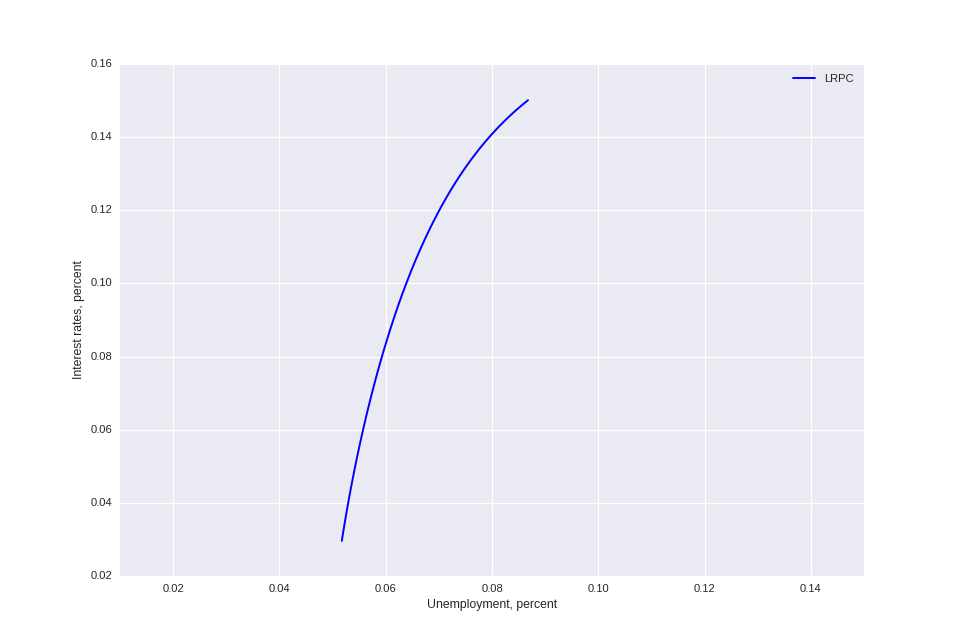

In [37]:
plt.figure(2)
LRPC_plot()

### Plotting the Money Demand Curve

The money demand relationship in the model is:
$$
\frac{M}{pY} = \frac{M/p}{Y} = \frac{g(q)}{4(1 - u)\left( \alpha_f (g(q) - c(q)) + y \right)}
$$

In [20]:
def MD(i):
    return g(q_ss(i,u_ss(i))) / (4 * (1 - u_ss(i)) * y_ss(i,u_ss(i)))

def MD_curve():
    x0 = [(i+1)**4-1 for i in i_grid]
    x1 = [MD(i) for i in i_grid]
    plt.plot(x0, x1, 'b-', label='MD curve')
    plt.scatter(i_ann_data,m_data)
    #plt.xlim(0.01,0.15)
    #plt.ylim(-0.5,2)
    plt.xlabel('Interest rates, percent')
    plt.ylabel('Money Demand (M1/NGDP), percent')
    plt.legend(loc='best')
    return plt.show()

<IPython.core.display.Javascript object>


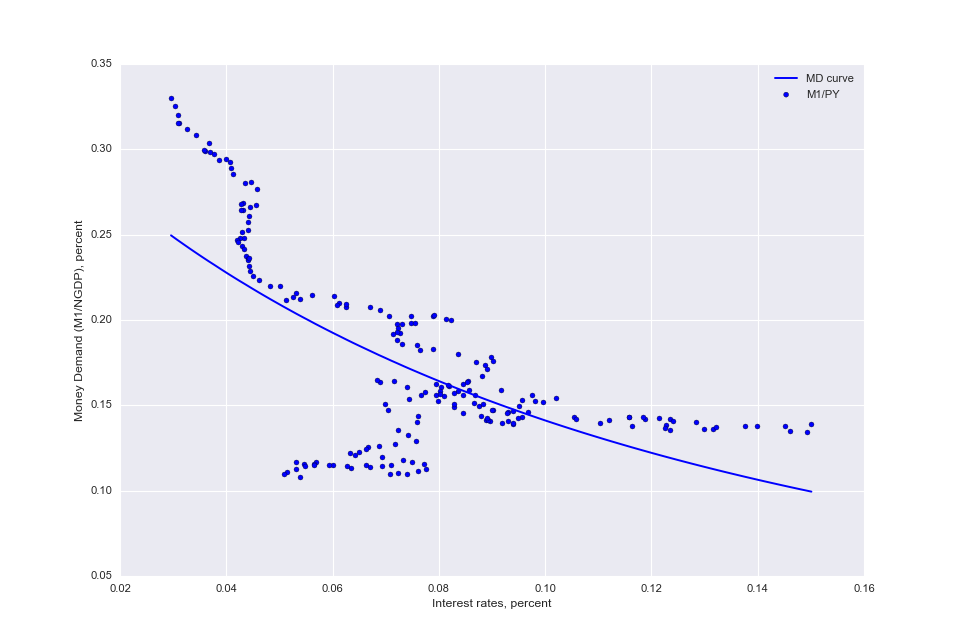

In [21]:
plt.figure(3)
MD_curve()

Next, I estimate money demand elasticity based on the annualized interest rate data and the calibrated money demand using a log-log specification: $\log(MD) = \alpha + \beta\log(i)$:

In [22]:
results2 = sm.OLS(np.log([MD(i) for i in i_grid]), sm.add_constant(np.log([(i+1)**4-1 for i in i_grid]))).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3495.
Date:                Tue, 26 Jul 2016   Prob (F-statistic):           1.85e-78
Time:                        17:20:31   Log-Likelihood:                 169.95
No. Observations:                 100   AIC:                            -335.9
Df Residuals:                      98   BIC:                            -330.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -3.3457      0.025   -131.436      0.0

In [23]:
MDela_model = results2.params[1]  # extract money demand elasticity
print('Estimated Money demand elasticity based on model data = ',MDela_model)

Estimated Money demand elasticity based on model data =  -0.590191776461


## Model with Monetary Shocks

In order to be able to solve and simulate the model with monetary shocks, the authors formulate the stochastic version of the model in a recursive fashion.

The state vector is $s = (u, i, y)$ where $u$. $i$ and $y$ follow different laws of motion:

$$
\hat{i} = \bar{i} + \rho_i (i - \bar{i}) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0,\sigma_{\epsilon_i})
\\
\hat{y} = \bar{y} + \rho_y (y - \bar{y}) + \epsilon_y, \quad \epsilon_y \sim \mathcal{N}(0,\sigma_{\epsilon_y})
\\
\hat{u}(s) = u - u \lambda_h(\theta(s)) + (1 - u)\delta
$$

<br>
The recursive equilibrium is formulated as:

$$
S(s) = y + b - \ell + \alpha_f(\frac{1}{1- \hat{u}(s)}) \left(g(q(s)) - c(q(s))\right) + \beta \mathbb{E}\left[(1 - \delta - (1 - \eta)\lambda_h(\theta(\hat{s})) S(\hat{s})\right]
$$
$$
1 = \frac{v'(q(s))}{g'(q(s))} - \frac{i}{\alpha_h(\frac{1}{1 - \hat{u}(s)})}
$$
$$
k = \beta \lambda_f(\theta(s))\eta S(s)
$$

**Solution Algorithm**

1. Initiate grid for $i$ and grid for $u$
2. For every i compute the transition probabilities to the other points of the grid
3. Initiate the value function vector
4. Solve the value function taking as given the state vector
5. 

#### Stochastic process for nominal interest rates

In the US data, the quarterly nominal interest rate of AAA bonds exhibits the following moments:

In [31]:
i_mean = np.mean(i_data)
i_acr = sm.tsa.stattools.acf(i_data,unbiased = True, nlags=1)[1]
i_std = np.std(i_data)

print('Average interest rate =','{:05.2f}'.format(i_mean*100),'%')
print('1st order autocorrelation =','{:05.2f}'.format(i_acr*100),'%')
print('Standard deviation =','{:05.2f}'.format(i_std*100),'%')

Average interest rate = 01.80 %
1st order autocorrelation = 98.62 %
Standard deviation = 00.63 %


As stated above, the nominal interest rate is assumed to follow the process:
$$
\hat{i} = \bar{i} + \rho_i (i - \bar{i}) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0,\sigma_{\epsilon_i})
$$

The unconditional variance of the stationary distribution of $i$ is: $ \sigma_i^2 = \dfrac{\sigma_{\epsilon_i}^2}{(1 - \rho_i^2)}$ and $\hat{i}$ conditional on $i$ follows the distribution $\mathcal{N}(\bar{i} + \rho_i (i - \bar{i}),\sigma_{\epsilon_i})$.

Taking $\sigma_i$ and $\rho_i$ from the data, the standard deviation of the process error term is defined as follows:
$$
\sigma_{\epsilon_i} = \sigma_i (1 - \rho_i^2)^{1/2}
$$

To simulate the model with shocks, we can either use an approximation of the value function or a discretization of the state space of $i$. We will proceed with the second option using Tauchen (1986) method to approximate the continuous state AR(1) process by a finite state Markov chain with state space $\{i_0,...,i_{n-1}\}$ and transition matrix $P$:

1. Construct a $n$ points grid (state space) of values for $i$ with the following assigned values:
    * $i_0 = -m \sigma_i$
    * $i_{n-1} = m \sigma_i$
    * $i_j = i_{j-1} + s$ where $s = \dfrac{i_{n-1} + i_0}{n-1}$ where $F$ is the cdf of the normal distribution $\mathcal{N}(0,\sigma_{\epsilon_i})$
2. Assign the following probabilities $P(i_k,i_j)$ to the grid point $i_j$ conditional on $i_k$:
    * For $j = 0$ assign the probability $P(i_k,i_0) = F(i_0 - \bar{i} - \rho_i (i_{k} - \bar{i}) + s /2)$
    * For $j = n-1$ assign the probability $P(i_k,i_{n-1}) = 1 - F(i_{n-1} - \bar{i} - \rho_i (i_{k} - \bar{i}) - s/2)$
    * Otherwise assign the probability $P(i_k,i_j) = F(i_{j} - \bar{i} - \rho_i (i_{k} - \bar{i}) + s/2) - F(i_{j} - \bar{i} - \rho_i (i_{k} - \bar{i}) - s/2)$
    
I implement this method below:

In [32]:
from scipy.stats import norm

def tauchen(i_acr, i_std, i_mean, m = 3, n = 6):
    x_max = i_mean + m * i_std  
#     x_max = i_max
    x_min = i_mean - m * i_std
#     x_min = i_min
    x_grid = np.linspace(x_min, x_max, n)  # Grid points
    eps_i_std = i_std * np.sqrt(1 - i_acr ** 2) # STD of the error of the AR(1) process
    
    x_step = (x_max - x_min) / (n - 1)  # Step of the grid

    P = np.empty((n, n))  # Markov transition matrix

    F = norm(loc=0,scale=eps_i_std).cdf
    
    # Use Tauchen's method to populate P
    for k in range(n):
        z = i_mean + i_acr * (x_grid[k] - i_mean) 
        P[k,0] = F(x_grid[0] - z + 0.5 * x_step)
        P[k,n-1] = 1 - F(x_grid[n-1] - z - 0.5 * x_step)
        for j in range(1,n-1):
            P[k,j] = F(x_grid[j] - z + 0.5 * x_step) - F(x_grid[j] - z - 0.5 * x_step)
    return P

# Integrate over the cdf of the distribution below to use the continuous AR(1) process instead of discretization
# def F(i):  # Normal distribution 
#     return norm((i_mean + i_std * (i - i_mean)), eps_i_std)

#### Value Function Iteration

$$
S(s) = y + b - \ell + \alpha_f(\frac{1}{1- \hat{u}(s)}) \left(g(q(s)) - c(q(s))\right) + \beta \mathbb{E}\left[(1 - \delta - (1 - \eta)\lambda_h(\theta(\hat{s})) S(\hat{s})\right]
$$
$$
1 = \frac{v'(q(s))}{g'(q(s))} - \frac{i}{\alpha_h(\frac{1}{1 - \hat{u}(s)})}
$$
$$
k = \beta \lambda_f(\theta(s))\eta S(s)
$$

We set up below the Bellman operator defined above:

In [72]:
def bellman_operator(S):
    
    def theta(i,u): 
        #return opt.root(lambda x: k - beta * (p(x)/x) * eta * S_interp(i,u_hat(u,x)), 1, method='lm').x
        return opt.root(lambda x: k - beta * (p(x)/x) * eta * S_interp(u_hat(u,x),i), 1, method='lm').x

    def u_hat(u, theta):
        return u + (1 - u) * delta - u * min(p(theta),1)
    
    #initialize new S
    new_S = np.empty(S.shape)
      
    # Interpolate S from previous iteration over meshgrid of i and u
    #S_interp = interp.interp2d(i_grid, u_grid, S.T, kind='cubic')
    
    # Linear interpolation along u_grid
    S_interp = lambda u, j_i: np.interp(u,u_grid,S[:,j_i])
    
    for j_u, u in enumerate(u_grid):
        for j_i, i in enumerate(i_grid):
            
            # # compute new value of S for i and u using the discretized process
            #new_S[j_i,j_u] = y_ss(i, u) + uben - leis + beta * np.sum((1 - delta - (1 - eta) * p(theta(i_grid[j_i_hat],u))) * S_interp(i_grid[j_i_hat],u_hat(u,theta(i_grid[j_i_hat],u))) * P[j_i,j_i_hat] for j_i_hat in range(len(i_grid)))
            
            # Compute new value of S for i and u using linear interpolation over u_grid
            new_S[j_u,j_i] = y_ss(i, u) + uben - leis + beta * np.sum((1 - delta - (1 - eta) * p(theta(j_i_hat,u))) * S_interp(u_hat(u,theta(j_i_hat,u)),j_i_hat) * P[j_i,j_i_hat] for j_i_hat in range(len(i_grid)))
            
            # compute new value of S for i and u using the continuous process
            # new_S[j_i,j_u] = y_ss(i, u) + uben - leis + beta * integrate(lambda i_hat: (1 - delta - (1 - eta) * p(theta(i_hat,u))) * S_interp(i_hat,u_hat(u,theta(i,u))) * F(i).pdf(i_hat), -np.inf, np.inf)[0]
    
    return new_S

In [58]:
sum(j_i_hat for j_i_hat in list(range(len(i_grid))))

45

In [49]:
x_grid = np.linspace(1,10,100)
y_grid = np.linspace(1,10,100)
xy = x_grid * y_grid
sum_interp = interp.interp2d(x_grid,y_grid,xy)

C:\Program Files\Anaconda3\lib\site-packages\scipy\interpolate\fitpack.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=14,11 m=100 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [50]:
sum_interp(1,5)

array([ 4.60291962])

In [73]:
import compute_fp as qe

# Define the grids for i and u
u_max = 0.13
u_min = 0.05
i_max = max(i_data)
i_min = max(min(i_data), 0.0001)
i_grid = np.linspace(i_min, i_max, num=10)
u_grid = np.linspace(u_min, u_max, num=25)

P = tauchen(i_acr,i_std,i_mean,m=3,n=len(i_grid))
# P = tauchenQE(i_acr,eps_i_std,i_mean,m=3,n=len(i_grid))[1]

S_init = np.ones((u_grid.size, i_grid.size))  # Initialize S over two dimensions

S_star = qe.compute_fixed_point(bellman_operator, S_init, error_tol = 1e-3, max_iter = 100)

# S = S_init
# print("Starting value function iteration")
# for k in range(100):
#     print ('Current iterate = ', str(k))
#     S = bellman_operator(S)  
# S_star = bellman_operator(S)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
5            7.670e-01      4.538e+01         
10           9.391e-01      8.893e+01         
15           9.910e-01      1.334e+02         
20           9.963e-01      1.761e+02         
25           9.969e-01      2.208e+02         
30           9.970e-01      2.634e+02         
35           9.970e-01      3.076e+02         
40           9.970e-01      3.504e+02         
45           9.970e-01      3.946e+02         
50           9.970e-01      4.372e+02         
55           9.970e-01      4.812e+02         
60           9.970e-01      5.234e+02         
65           9.970e-01      5.673e+02         
70           9.970e-01      6.096e+02         
75           9.970e-01      6.535e+02         
80           9.970e-01      6.957e+02         
85           9.970e-01      7.397e+02         
90           9.970e-01      7.820e+02         
95           9.970e-01      8.259e+02         
100          9.

<IPython.core.display.Javascript object>


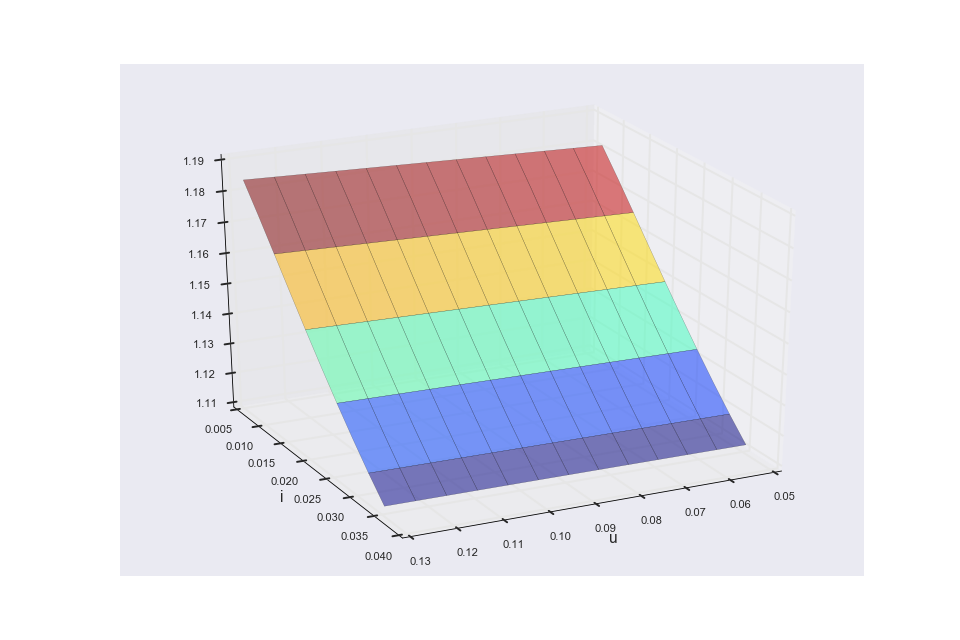

In [76]:
# plot value function
fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
ug, ig = np.meshgrid(u_grid, i_grid)
ax.plot_surface(ug,
                ig,
                S_star.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
#ax.set_zlim(, 200)
ax.set_xlabel('u', fontsize=14)
ax.set_ylabel('i', fontsize=14)
plt.show()

<IPython.core.display.Javascript object>


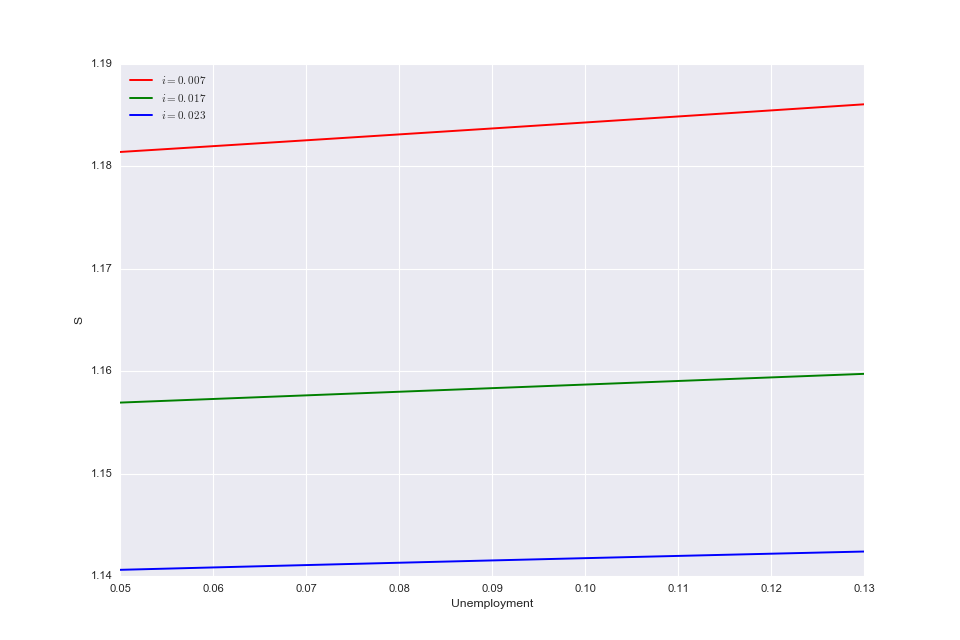

In [78]:
plt.figure(5)
plt.plot(u_grid,S_star[:,0],'-r', label=r'$i = %.3f$' % i_grid[0])
plt.plot(u_grid,S_star[:,3],'-g', label=r'$i = %.3f$' % i_grid[3])
plt.plot(u_grid,S_star[:,5],'-b', label=r'$i = %.3f$' % i_grid[5])
plt.legend(loc='upper left')
plt.xlabel('Unemployment')
plt.ylabel('S')
plt.show()

Now that we have the optimal value function, we can try to simulate the model using the historical data. That is, given interest rates from the data and the optimal value function we can compute the model implied unemployment path.



In [79]:
# First we interpolate the optimal value function
S_star_interp = interp.interp2d(i_grid, u_grid, S_star.T, kind='linear')

# Then we use the interpolation to compute theta resulting from the optimal value function
def theta_star(i,u): 
    return opt.root(lambda x: k - beta * (p(x)/x) * eta * S_star_interp(i,u_hat(u,x)), 1, method='lm').x

def u_hat_star(u, theta):
    return u + (1 - u) * delta - u * min(p(theta),1)

u_sim = np.empty(len(u_data))

u_sim[0] = u_data[28] # Initializing u with the first observation in the data

# Computes u_hat based on the previous period computed u and observed i
for k in range(1,len(u_data)):
    u_sim[k] = u_hat_star(u_sim[k-1],theta_star((i_data[28 + k]+1)**4-1,u_sim[k-1]))

ValueError: When on a regular grid with x.size = m and y.size = n, if z.ndim == 2, then z must have shape (n, m)

Then we plot both observed and simulated u

In [1]:
plt.figure(6)
dates = pd.date_range(start='1955-01-01',end='2005-12-31',freq='Q')
plt.plot(dates, u_sim, 'r-', label='Model')
plt.plot(dates, u_data, 'b-', label='Data')
#plt.xlim(0.01,0.15)
#plt.ylim(-0.5,2)
plt.ylabel('Unemployment, percent')
plt.legend(loc='best')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
u_sim[0]

In [ ]:
theta_star((i_data[28 + k]+1)**4-1,u_sim[0])